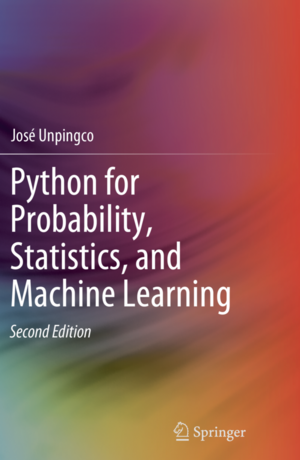

In [1]:
from IPython.display import Image
Image('../../Python_probability_statistics_machine_learning_2E.png',width=200)

<!-- # TODO: Elastic Net -->
<!-- # TODO: Nice intuition about ridge regression Data_Analysis_Data_Mining_Azzalini, p. 64 -->


We have referred to regularization in the section [ch:ml:sec:logreg](#ch:ml:sec:logreg), but we want to develop this important
idea more fully. Regularization is the mechanism by which we
navigate the bias/variance trade-off.  To get started, let's
consider a classic constrained least squares problem,

$$
\begin{aligned}
& \underset{\mathbf{x}}{\text{minimize}}
& & \Vert\mathbf{x}\Vert_2^2 \\
& \text{subject to:}
& & x_0 + 2 x_1 = 1
\end{aligned}
$$

 where $\Vert\mathbf{x}\Vert_2=\sqrt{x_0^2+x_1^2}$ is the
$L_2$ norm.  Without the constraint, it would be easy to minimize
the objective function --- just take $\mathbf{x}=0$. Otherwise,
suppose we somehow know  that $\Vert\mathbf{x}\Vert_2<c$, then
the locus of points defined by this inequality is the circle in
[Figure](#fig:regularization_001). The constraint is the line in
the same figure. Because every value of $c$ defines a circle, the
constraint is satisfied  when the circle touches the line. The
circle can touch the line at many different points, but we are
only interested in the smallest such circle because this is a
minimization problem.  Intuitively, this means that we *inflate* a
$L_2$  ball at the origin and stop when it just touches the
contraint.  The point of contact is our $L_2$ minimization
solution.   

<!-- dom:FIGURE: [fig-machine_learning/regularization_001.png, width=500 frac=0.75] The solution of the constrained $L_2$ minimization problem is at the point where the constraint (dark line) intersects the $L_2$ ball (gray circle) centered at the origin. The point of intersection is indicated by the dark circle. The two neighboring squares indicate points on the line that are close to the solution. <div id="fig:regularization_001"></div> -->
<!-- begin figure -->
<div id="fig:regularization_001"></div>

<p>The solution of the constrained $L_2$ minimization problem is at the point where the constraint (dark line) intersects the $L_2$ ball (gray circle) centered at the origin. The point of intersection is indicated by the dark circle. The two neighboring squares indicate points on the line that are close to the solution.</p>
<img src="fig-machine_learning/regularization_001.png" width=500>

<!-- end figure -->



We can obtain the same result using the method of Lagrange
multipliers. We can rewrite the entire $L_2$ minimization problem
as one objective function using the Lagrange multiplier,
$\lambda$,

$$
J(x_0,x_1,\lambda) = x_0^2+x_1^2 + \lambda (1-x_0-x_1)
$$

 and solve this as an ordinary function using calculus. Let's
do this using Sympy.

In [2]:
import sympy as S
S.var('x:2 l',real=True)
J=S.Matrix([x0,x1]).norm()**2 + l*(1-x0-2*x1)
sol=S.solve(map(J.diff,[x0,x1,l]))
print(sol)

{l: 2/5, x0: 1/5, x1: 2/5}


**Programming Tip.**

Using  the `Matrix` object is overkill for this problem but it
does demonstrate how Sympy's matrix machinery works. In this case,
we are using the `norm` method to compute the $L_2$  norm of the
given elements. Using `S.var` defines Sympy variables and injects
them into the global namespace. It is more Pythonic to do
something like `x0 = S.symbols('x0',real=True)` instead but the
other way is quicker, especially for variables with many
dimensions.



 The solution defines the exact point where the line is
tangent to the circle in [Figure](#fig:regularization_001).  The
Lagrange multiplier has incorporated the constraint into the objective
function.

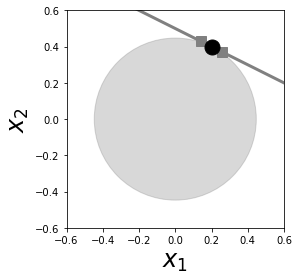

In [3]:
%matplotlib inline

import numpy as np
from numpy import pi, linspace, sqrt
from matplotlib.patches import Circle
from matplotlib.pylab import subplots

x1 = linspace(-1,1,10)
dx=linspace(.7,1.3,3)
fline = lambda x:(1-x)/2.

fig,ax=subplots()
_=ax.plot(dx*1/5,fline(dx*1/5),'s',ms=10,color='gray')
_=ax.plot(x1,fline(x1),color='gray',lw=3)
_=ax.add_patch(Circle((0,0),1/sqrt(5),alpha=0.3,color='gray'))
_=ax.plot(1/5,2/5,'o',color='k',ms=15)
_=ax.set_xlabel('$x_1$',fontsize=24)
_=ax.set_ylabel('$x_2$',fontsize=24)
_=ax.axis((-0.6,0.6,-0.6,0.6))
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('fig-machine_learning/regularization_001.png')

There is something subtle and very important about the nature of the solution,
however. Notice that there are other points very close to the solution on the
circle, indicated by the squares in [Figure](#fig:regularization_001). This
closeness could be a good thing, in case it helps us actually find a solution
in the first place, but it may be unhelpful in so far as it creates ambiguity.
Let's hold that thought and try the same problem using the $L_1$ norm instead
of the $L_2$ norm. Recall that

$$
\Vert \mathbf{x}\Vert_1 = \sum_{i=1}^d \vert x_i \vert
$$

 where $d$ is the dimension of the vector $\mathbf{x}$. Thus, we can
reformulate the same problem in the $L_1$  norm as in the following,

$$
\begin{aligned}
& \underset{\mathbf{x}}{\text{minimize}}
& & \Vert\mathbf{x}\Vert_1 \\
& \text{subject to:}
& & x_1 + 2 x_2 = 1
\end{aligned}
$$

  It turns out that this problem is somewhat harder to
solve using Sympy, but we have convex optimization modules in Python
that can help.

In [4]:
from cvxpy import Variable, Problem, Minimize, norm1, norm
x=Variable((2,1),name='x')
constr=[np.matrix([[1,2]])*x==1]
obj=Minimize(norm1(x))
p= Problem(obj,constr)
p.solve()
print(x.value)

[[1.31394645e-29]
 [5.00000000e-01]]


**Programming Tip.**

The `cvxy` module provides a unified and accessible interface to the powerful
`cvxopt` convex optimization package, as well as other open-source solver
packages.



 As shown in [Figure](#fig:regularization_002), the constant-norm
contour in the $L_1$ norm is shaped like a diamond instead of a circle.
Furthermore, the solutions found in each case are different.  Geometrically,
this is because inflating the circular $L_2$ reaches out in all directions
whereas the $L_1$ ball creeps out along the principal axes.  This effect is
much more pronounced in higher dimensional spaces where $L_1$-balls get more
spikey  [^spikey].  Like the $L_2$ case, there are also neighboring points on
the constraint line, but notice that these are not close to the boundary of the
corresponding $L_1$ ball, as they were in the $L_2$ case.  This means that
these would be harder to confuse with the optimal solution because they
correspond to a substantially different $L_1$ ball.

[^spikey]: We discussed the geometry of high dimensional space 
when we covered the curse of dimensionality in the
statistics chapter.

To double-check our earlier $L_2$ result, we can also use the
`cvxpy` module to find the $L_2$ solution as in the following
code,

In [5]:
constr=[np.matrix([[1,2]])*x==1]
obj=Minimize(norm(x,2)) #L2 norm
p= Problem(obj,constr)
p.solve()
print(x.value)

[[0.2]
 [0.4]]


 The only change to the code is the $L_2$ norm and we get
the same solution as before.  

Let's see what happens in higher dimensions for both $L_2$ and
$L_1$ as we move from two dimensions to four dimensions.

In [6]:
x=Variable((4,1),name='x')
constr=[np.matrix([[1,2,3,4]])*x==1]
obj=Minimize(norm1(x))
p= Problem(obj,constr)
p.solve()
print(x.value)

[[-3.64540020e-29]
 [-7.29271858e-29]
 [-8.32902339e-23]
 [ 2.50000000e-01]]


 And also in the $L_2$ case with the following code,

In [7]:
constr=[np.matrix([[1,2,3,4]])*x==1]
obj=Minimize(norm(x,2))
p= Problem(obj,constr)
p.solve()
print(x.value)

[[0.03333333]
 [0.06666667]
 [0.1       ]
 [0.13333333]]


 Note that the $L_1$ solution has selected out only one
dimension for the solution, as the other components are
effectively zero. This is not so with the $L_2$ solution, which
has meaningful elements in multiple coordinates.  This is because
the $L_1$ problem has many pointy corners in the four dimensional
space that poke at the hyperplane that is defined by the
constraint. This essentially means the subsets (namely, the points
at the corners) are found as solutions because these touch the
hyperplane. This effect becomes more pronounced in higher
dimensions, which is the main benefit of using the $L_1$ norm
as we will see in the next section.

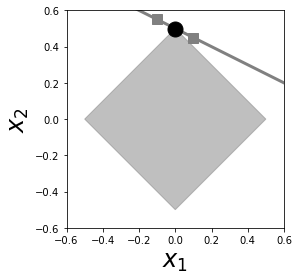

In [8]:
from matplotlib.patches import Rectangle, RegularPolygon

r=RegularPolygon((0,0),4,1/2,pi/2,alpha=0.5,color='gray')
fig,ax=subplots()
dx = np.array([-0.1,0.1])
_=ax.plot(dx,fline(dx),'s',ms=10,color='gray')
_=ax.plot(x1,fline(x1),color='gray',lw=3)
_=ax.plot(0,1/2,'o',color='k',ms=15)
_=ax.add_patch(r)
_=ax.set_xlabel('$x_1$',fontsize=24)
_=ax.set_ylabel('$x_2$',fontsize=24)
_=ax.axis((-0.6,0.6,-0.6,0.6))
_=ax.set_aspect(1)
fig.tight_layout()
fig.savefig('fig-machine_learning/regularization_002.png')

<!-- dom:FIGURE: [fig-machine_learning/regularization_002.png, width=500 frac=0.75] The diamond is the $L_1$ ball in two dimensions and the line is the constraint. The point of intersection is the solution to the optimization problem. Note that for $L_1$ optimization, the two nearby points on the constraint (squares) do not touch the $L_1$ ball. Compare this with [Figure](#fig:regularization_001). <div id="fig:regularization_002"></div> -->
<!-- begin figure -->
<div id="fig:regularization_002"></div>

<p>The diamond is the $L_1$ ball in two dimensions and the line is the constraint. The point of intersection is the solution to the optimization problem. Note that for $L_1$ optimization, the two nearby points on the constraint (squares) do not touch the $L_1$ ball. Compare this with [Figure](#fig:regularization_001).</p>
<img src="fig-machine_learning/regularization_002.png" width=500>

<!-- end figure -->


<!-- p. 168 D:\Volume2_Indexed\Statistical_Machine_Learning_Notes_Tibshirani.pdf -->

## Ridge Regression

Now that we have a sense of the geometry of the situation, let's revisit
our classic linear regression probem. To recap, we want to solve the following
problem,

$$
\min_{\boldsymbol{\beta}\in \mathbb{R}^p} \Vert y - \mathbf{X}\boldsymbol{\beta}\Vert
$$

 where $\mathbf{X}=\left[
\mathbf{x}_1,\mathbf{x}_2,\ldots,\mathbf{x}_p \right]$ and $\mathbf{x}_i\in
\mathbb{R}^n$. Furthermore, we assume that the $p$ column vectors are linearly
independent (i.e., $\texttt{rank}(\mathbf{X})=p$). Linear regression produces
the $\boldsymbol{\beta}$ that minimizes the mean squared error above.  In the
case where $p=n$, there is a unique solution to this problem. However, when
$p<n$, then there are infinitely many solutions.

To make this concrete, let's work this out using Sympy. First,
let's define an example $\mathbf{X}$ and $\mathbf{y}$ matrix,

In [9]:
import sympy as S
from sympy import Matrix
X = Matrix([[1,2,3],
            [3,4,5]])
y = Matrix([[1,2]]).T

  Now, we can define our coefficient vector $\boldsymbol{\beta}$
using the following code,

In [10]:
b0,b1,b2=S.symbols('b:3',real=True)
beta = Matrix([[b0,b1,b2]]).T # transpose

 Next, we define the objective function we are trying to minimize

In [11]:
obj=(X*beta -y).norm(ord=2)**2

**Programming Tip.**

The Sympy `Matrix` class has useful methods like the `norm` function
used above to define the objective function. The `ord=2` means we want
to use the $L_2$ norm. The expression in parenthesis evaluates to a
`Matrix` object.



 Note that it is helpful to define real variables using
the keyword argument whenever applicable because it relieves
Sympy's internal machinery of dealing with complex numbers.
Finally, we can use calculus to solve this by setting the
derivatives of the objective function to zero.

In [12]:
sol=S.solve([obj.diff(i) for i in beta])
beta.subs(sol)

Matrix([
[        b2],
[1/2 - 2*b2],
[        b2]])

 Notice that the solution does not uniquely specify all the components
of the `beta` variable. This is a consequence of the $p<n$ nature of this
problem where $p=2$ and $n=3$.  While the the existence of this ambiguity does
not alter the solution,

In [13]:
obj.subs(sol)

0

 But it does change the length of the solution vector
`beta`,

In [14]:
beta.subs(sol).norm(2)

sqrt(2*b2**2 + (2*b2 - 1/2)**2)

 If we want to minimize this length we can easily
use the same calculus as before,

In [15]:
S.solve((beta.subs(sol).norm()**2).diff())

[1/6]

 This provides the solution of minimum length
in the $L_2$ sense,

In [16]:
betaL2=beta.subs(sol).subs(b2,S.Rational(1,6))
betaL2

Matrix([
[1/6],
[1/6],
[1/6]])

 But what is so special about solutions of minimum length? For machine
learning, driving the objective function to zero is symptomatic of overfitting
the data. Usually, at the zero bound, the machine learning method has
essentially memorized the training data, which is bad for generalization. Thus,
we can effectively stall this problem by defining a region for the solution
that is away from the zero-bound.

$$
\begin{aligned}
& \underset{\boldsymbol{\beta}}{\text{minimize}}
& & \Vert y - \mathbf{X}\boldsymbol{\beta}\Vert_2^2 \\
& \text{subject to:}
& & \Vert\boldsymbol{\beta}\Vert_2 < c
\end{aligned}
$$

 where $c$ is the tuning parameter. Using the same process as before,
we can re-write this as the following,

$$
\min_{\boldsymbol{\beta}\in\mathbb{R}^p}\Vert y-\mathbf{X}\boldsymbol{\beta}\Vert_2^2 +\alpha\Vert\boldsymbol{\beta}\Vert_2^2
$$

 where $\alpha$ is the tuning parameter. These are the *penalized* or
Lagrange forms of these problems derived from the constrained versions. The
objective function is penalized by the $\Vert\boldsymbol{\beta}\Vert_2$ term.
For $L_2$ penalization, this is called *ridge* regression.    This is
implemented in Scikit-learn as `Ridge`. The following code sets this up for
our example,

In [17]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=100.0,fit_intercept=False)
clf.fit(np.array(X).astype(float),np.array(y).astype(float))

Ridge(alpha=100.0, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

 Note that the `alpha` scales of the penalty for the
$\Vert\boldsymbol{\beta}\Vert_2$. We set the `fit_intercept=False` argument to
omit the extra offset term from our example. The corresponding solution is the
following,

In [18]:
print(clf.coef_)

[[0.0428641  0.06113005 0.07939601]]


 To double-check the solution, we can use some optimization tools from
Scipy and our previous Sympy analysis, as in the following,

In [19]:
from scipy.optimize import minimize
f   = S.lambdify((b0,b1,b2),obj+beta.norm()**2*100.)
g   = lambda x:f(x[0],x[1],x[2])
out = minimize(g,[.1,.2,.3]) # initial guess
out.x

array([0.0428641 , 0.06113005, 0.07939601])

**Programming Tip.**

We had to define the additional `g` function from the lambda function we
created from the Sympy expression in `f` because the `minimize` function
expects a single object vector as input instead of a three separate arguments.



 which produces the same answer as the `Ridge` object. To
better understand the meaning of this result, we can re-compute the
mean squared error solution to this problem in one step using matrix
algebra instead of calculus,

In [20]:
betaLS=X.T*(X*X.T).inv()*y
betaLS

Matrix([
[1/6],
[1/6],
[1/6]])

 Notice that this solves the posited problem exactly,

In [21]:
X*betaLS-y

Matrix([
[0],
[0]])

 This means that the first term in the objective function
goes to zero,

$$
\Vert y-\mathbf{X}\boldsymbol{\beta}_{LS}\Vert=0
$$

 But, let's examine the $L_2$ length of this solution versus
the ridge regression solution,

In [22]:
print(betaLS.norm().evalf(), np.linalg.norm(clf.coef_))

0.288675134594813 0.10898596412575512


 Thus, the ridge regression solution is shorter in the $L_2$
sense, but the first term in the objective function is not zero for
ridge regression,

In [23]:
print((y-X*clf.coef_.T).norm()**2)

1.86870864136429


 Ridge regression solution trades fitting error
($\Vert y-\mathbf{X} \boldsymbol{\beta}\Vert_2$) for solution
length ($\Vert\boldsymbol{\beta}\Vert_2$). 

Let's see this in action with a familiar example from
[ch:stats:sec:nnreg](#ch:stats:sec:nnreg).  Consider [Figure](#fig:regularization_003).
For this example, we created our usual chirp signal and attempted to
fit it with a high-dimensional polynomial, as we did in
the section [ch:ml:sec:cv](#ch:ml:sec:cv).  The lower panel is the same except with ridge
regression. The shaded gray area is the space between the true signal
and the approximant in both cases. The horizontal hash marks indicate
the subset of $x_i$ values that each regressor was trained on.
Thus, the training set represents a non-uniform sample of the
underlying chirp waveform.  The top panel shows the usual polynomial
regression. Note that the regressor fits the given points extremely
well, but fails at the endpoint. The ridge regressor misses many of
the points in the middle, as indicated by the gray area, but does not
overshoot at the ends as much as the plain polynomial regression. This
is the basic trade-off for ridge regression. The Jupyter
notebook corresponding to this section has the code for this graph, but the main steps
are shown in the following,

In [24]:
# create chirp signal
xi = np.linspace(0,1,100)[:,None]
# sample chirp randomly
xin= np.sort(np.random.choice(xi.flatten(),20,replace=False))[:,None]
# create sampled waveform
y = np.cos(2*pi*(xin+xin**2))
# create full waveform for reference
yi = np.cos(2*pi*(xi+xi**2))

# create polynomial features
from sklearn.preprocessing import PolynomialFeatures
qfit = PolynomialFeatures(degree=8) # quadratic
Xq = qfit.fit_transform(xin)
# reformat input as polynomial
Xiq = qfit.fit_transform(xi)

from sklearn.linear_model import LinearRegression
lr=LinearRegression() # create linear model 
lr.fit(Xq,y) # fit linear model

# create ridge regression model and fit
clf = Ridge(alpha=1e-9,fit_intercept=False)
clf.fit(Xq,y)

Ridge(alpha=1e-09, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

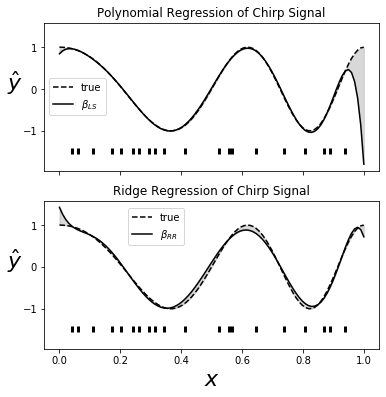

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
from numpy import cos, pi

np.random.seed(1234567)
xi = np.linspace(0,1,100)[:,None]
xin = np.linspace(0,1,20)[:,None]
xin= np.sort(np.random.choice(xi.flatten(),20,replace=False))[:,None]
f0 = 1 # init frequency
BW = 2
y = cos(2*pi*(f0*xin+(BW/2.0)*xin**2))
yi = cos(2*pi*(f0*xi+(BW/2.0)*xi**2))

qfit = PolynomialFeatures(degree=8) # quadratic
Xq = qfit.fit_transform(xin)
Xiq = qfit.fit_transform(xi)

lr=LinearRegression() # create linear model 
_=lr.fit(Xq,y)

fig,axs=subplots(2,1,sharex=True,sharey=True)
fig.set_size_inches((6,6))
ax=axs[0]
_=ax.plot(xi,yi,label='true',ls='--',color='k')
_=ax.plot(xi,lr.predict(Xiq),label=r'$\beta_{LS}$',color='k')
_=ax.legend(loc=0)
_=ax.set_ylabel(r'$\hat{y}$  ',fontsize=22,rotation='horizontal')
_=ax.fill_between(xi.flatten(),yi.flatten(),lr.predict(Xiq).flatten(),color='gray',alpha=.3)
_=ax.set_title('Polynomial Regression of Chirp Signal')
_=ax.plot(xin, -1.5+np.array([0.01]*len(xin)), '|', color='k',mew=3)

clf = Ridge(alpha=1e-9,fit_intercept=False)
_=clf.fit(Xq,y)
ax=axs[1]
_=ax.plot(xi,yi,label=r'true',ls='--',color='k')
_=ax.plot(xi,clf.predict(Xiq),label=r'$\beta_{RR}$',color='k')
_=ax.legend(loc=(0.25,0.70))
_=ax.fill_between(xi.flatten(),yi.flatten(),clf.predict(Xiq).flatten(),color='gray',alpha=.3)
# add rug plot
_=ax.plot(xin, -1.5+np.array([0.01]*len(xin)), '|', color='k',mew=3)
_=ax.set_xlabel('$x$',fontsize=22)
_=ax.set_ylabel(r'$\hat{y}$  ',fontsize=22,rotation='horizontal')
_=ax.set_title('Ridge Regression of Chirp Signal')
fig.savefig('fig-machine_learning/regularization_003.png')

<!-- dom:FIGURE: [fig-machine_learning/regularization_003.png, width=500 frac=0.85] The top figure shows polynomial regression and the lower panel shows polynomial ridge regression. The ridge regression does not match as well throughout most of the domain, but it does not flare as violently at the ends.  This is because the ridge constraint holds the coefficient vector down at the expense of poorer performance along the middle of the domain. <div id="fig:regularization_003"></div> -->
<!-- begin figure -->
<div id="fig:regularization_003"></div>

<p>The top figure shows polynomial regression and the lower panel shows polynomial ridge regression. The ridge regression does not match as well throughout most of the domain, but it does not flare as violently at the ends.  This is because the ridge constraint holds the coefficient vector down at the expense of poorer performance along the middle of the domain.</p>
<img src="fig-machine_learning/regularization_003.png" width=500>

<!-- end figure -->


## Lasso Regression

Lasso regression follows the same basic pattern as ridge regression,
except with the $L_1$ norm in the objective function.

$$
\min_{\boldsymbol{\beta}\in\mathbb{R}^p}\Vert y-\mathbf{X}\boldsymbol{\beta}\Vert^2 +\alpha\Vert\boldsymbol{\beta}\Vert_1
$$

 The interface in Scikit-learn is likewise the same. 
The following is the same problem as before using lasso
instead of ridge regression,

In [26]:
X = np.matrix([[1,2,3],
               [3,4,5]])
y = np.matrix([[1,2]]).T
from sklearn.linear_model import Lasso
lr = Lasso(alpha=1.0,fit_intercept=False)
_=lr.fit(X,y)
print(lr.coef_)

[0.         0.         0.32352941]


 As before, we can use the optimization tools in Scipy to solve this
also,

In [27]:
from scipy.optimize import fmin
obj = 1/4.*(X*beta-y).norm(2)**2 + beta.norm(1)*l
f = S.lambdify((b0,b1,b2),obj.subs(l,1.0))
g = lambda x:f(x[0],x[1],x[2])
fmin(g,[0.1,0.2,0.3])

Optimization terminated successfully.
         Current function value: 0.360297
         Iterations: 121
         Function evaluations: 221


array([2.27469304e-06, 4.02831864e-06, 3.23134859e-01])

**Programming Tip.**

The `fmin` function from Scipy's optimization module uses an
algorithm that does not depend upon derivatives. This is useful
because, unlike the $L_2$ norm, the $L_1$ norm has sharp corners
that make it harder to estimate derivatives.



 This result matches the previous one from the
Scikit-learn `Lasso` object. Solving it using Scipy is motivating
and provides a good sanity check, but specialized algorithms are
required in practice. The following code block re-runs the lasso
with varying $\alpha$ and plots the coefficients in [Figure](#fig:regularization_004). Notice that as $\alpha$ increases, all
but one of the coefficients is driven to zero. Increasing $\alpha$
makes the trade-off between fitting the data in the $L_1$ sense
and wanting to reduce the number of nonzero coefficients
(equivalently, the number of features used) in the model. For a
given problem, it may be more practical to focus on reducing the
number of features in the model (i.e., large $\alpha$) than the
quality of the data fit in the training data. The lasso provides a
clean way to navigate this trade-off.

The following code loops over a set of $\alpha$ values and
collects the corresponding lasso coefficients to be plotted
in [Figure](#fig:regularization_004)

In [28]:
o=[]
alphas= np.logspace(-3,0,10)
for a in alphas:
    clf = Lasso(alpha=a,fit_intercept=False)
    _=clf.fit(X,y)
    o.append(clf.coef_)

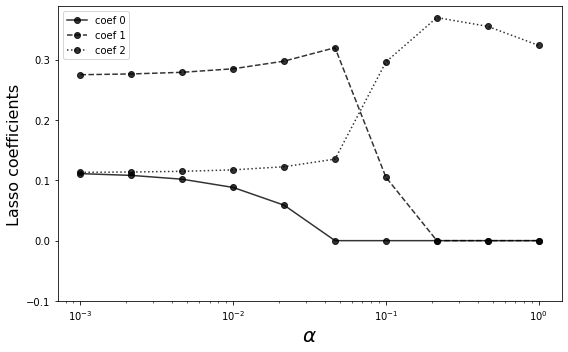

In [29]:
fig,ax=subplots()
fig.set_size_inches((8,5))
k=np.vstack(o)
ls = ['-','--',':','-.']
for i in range(k.shape[1]):
    _=ax.semilogx(alphas,k[:,i],'o-',
                label='coef %d'%(i),
                color='k',ls=ls[i],
                alpha=.8,)

_=ax.axis(ymin=-1e-1)
_=ax.legend(loc=0)
_=ax.set_xlabel(r'$\alpha$',fontsize=20)
_=ax.set_ylabel(r'Lasso coefficients',fontsize=16)
fig.tight_layout()
fig.savefig('fig-machine_learning/regularization_004.png')

<!-- dom:FIGURE: [fig-machine_learning/regularization_004.png, width=500 frac=0.85] As $\alpha$ increases, more of the model coefficients are driven to zero for lasso regression.  <div id="fig:regularization_004"></div> -->
<!-- begin figure -->
<div id="fig:regularization_004"></div>

<p>As $\alpha$ increases, more of the model coefficients are driven to zero for lasso regression.</p>
<img src="fig-machine_learning/regularization_004.png" width=500>

<!-- end figure -->